## Barabasi-Albert Network

### Import Modules

In [1]:
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy import stats
from collections import deque
import networkx as nx
import math as m

### Network Initialize

In [4]:
size_list = [1000, 5000, 10000, 20000]
mean_degree = int(input("Target Mean Degree : ").strip())

Target Mean Degree : 10


### BA Network Class

In [13]:
class BA:
    def __init__(self, mean_degree, size_list=[]):
        self.size = mean_degree + 1
        self.mean_degree = mean_degree
        self.size_list = size_list
        self.degree = dict()
        self.adjacent = dict()
        self.pref = dict()
        self.num_of_links = dict()
        for item in self.size_list:
            self.degree[item] = dict()
            self.adjacent[item] = dict()
            self.pref[item] = dict()
            self.num_of_links[item] = 0    
        self.largest_cluster = []
    
    @staticmethod
    def power_law(x, a, b):
        return b * np.power(x, a)
    
    @staticmethod
    def log_binning(data, start, length):
        maxbin = m.ceil(np.log10(max(data)))
        hist, bins = np.histogram(data, bins=np.logspace(start, maxbin, num=length, endpoint=True, base=10.0))
        bin_centers = (bins[1:] + bins[:-1]) * 0.5
        delt = bins[1:] - bins[:-1]
        # print(maxbin, delt, sum(hist))
        hist = hist / delt / sum(hist)
        return bin_centers, hist
    
    def generate(self):
        ## Make Seed ##
        self.size = self.mean_degree + 1
        for size in self.size_list:
            for node in range(self.mean_degree + 1):
                self.adjacent[size][node] = [node2 for node2 in range(self.size) if node != node2]
                self.degree[size][node] = self.mean_degree
                self.num_of_links[size] += len(self.adjacent[size][node])
                self.pref[size][node] = self.degree[size][node] / (self.num_of_links[size] / 2.0)

        ## Generate BA ##
        for size in self.size_list:
            for self.size in tqdm(range(self.mean_degree + 1, size)):
                nodes = [i for i in range(self.size)]
                prob = np.array(list(self.pref[size].values())) / sum(list(self.pref[size].values()))
                samp_nodes = np.random.choice(nodes, self.mean_degree, p=prob)
                self.degree[size][self.size] = 0
                self.pref[size][self.size] = 0

                for node in samp_nodes:
                    self.degree[size][node] += 1
                    self.degree[size][self.size] += 1

                    self.adjacent[size][node].append(self.size)
                    if self.size in self.adjacent[size].keys():
                        self.adjacent[size][self.size].append(node)
                    else:
                        self.adjacent[size][self.size] = [node]

                    self.num_of_links[size] += 1
                    self.pref[size][node] = self.degree[size][node] / (self.num_of_links[size] / 2.0)
                    self.pref[size][self.size] = self.degree[size][self.size] / (self.num_of_links[size] / 2.0)
    
    def plot_degree_dist(self):
        dat = sorted(self.degree.values(), reverse=False)
        plt.figure(figsize=(10, 16))
        sns.countplot(dat)
        plt.show()
    
    def loglog_plot(self, cutoff):
        fig = plt.figure(figsize=(10, 8), facecolor=(0.9, 0.9, 0.9))
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('degree')
        plt.ylabel('distribution')
        plt.xlim(10000, 1000000000)
        plt.ylim(0.00001,100)
        plt.grid()
                                                   
        for enum, size in enumerate(self.size_list):
            enum += 1
            dat = sorted(self.degree[size].values(), reverse=False)

            x_bin, y_bin = self.log_binning(dat, 0, 30)
            sum_y = sum(y_bin)
            data = dict()
            for x, y in zip(x_bin, y_bin):
                data[x] = y

            data0 = dict()

            for item in dat:
                if item in data0.keys():
                    data0[item] += 1
                else:
                    data0[item] = 1

            data_buf = sorted(data0.items(), key=lambda x:x[0], reverse=False)   
            x0 = np.array(list(map(lambda x:x[0], data_buf)))
            y0 = np.array(list(map(lambda x:x[1], data_buf)))
            sum_y0 = sum(y0)
            y0 = y0 / sum_y0

            cum = dict()

            for key, val in zip(x_bin, y_bin):
                buf = x_bin[x_bin >= key]
                for item in buf:
                    if key in cum.keys():
                        cum[key] += data[item]
                    else:
                        cum[key] = data[item]

            x_2 = np.array(list(cum.keys()))
            y_2 = np.array(list(cum.values()))
            y_2 = y_2 / sum(y_2)


            popt, pcov = curve_fit(self.power_law, xdata=x_2[cutoff:], ydata=y_2[cutoff:], method='dogbox')
    
            #plt.scatter(x_bin[9:] * size * 2, y_bin[9:], s=55.0, marker='o', color=(1.0 / enum,0.0,1.0 / enum), alpha=1.0, edgecolors=(0.0,0.0,0.0), label="BA Network, size=" + str(size), zorder=2)
            plt.scatter(x_2[cutoff:] * size * 2, y_2[cutoff:] * 10, s=55.0, marker='o', color=(0.0,1.0 / enum,1.0 / enum), alpha=1.0, edgecolors=(0.0,0.0,0.0), label="Size=" + str(size), zorder=2)
            #plt.scatter(x0[9:] * size * 2, y0[9:], s=55.0, marker='o', color=(1.0 / enum,1.0 / enum,0.0), alpha=1.0, edgecolors=(0.0,0.0,0.0), label="Raw BA Network , size=" + str(size), zorder=2)
            if size==max(self.size_list):
                plt.scatter(x_2 * size * 2, self.power_law(x_2, *popt) * 100, s=55.0, marker='o', color=(1.0,1.0,1.0), alpha=1.0, edgecolors=(0.0,0.0,0.0), label="gamma="+str(-popt[0]), zorder=2)
                plt.plot(x_2 * size * 2, self.power_law(x_2, *popt) * 100, c=(1.0,0.0,0.0), zorder=1)
        
        plt.legend()
        plt.show()
        fig.savefig("./ba.png")   

In [14]:
ba = BA(mean_degree, size_list)

In [15]:
ba.generate()

100%|███████████████████████████████████████████████████████████| 19989/19989 [01:19<00:00, 251.13it/s]


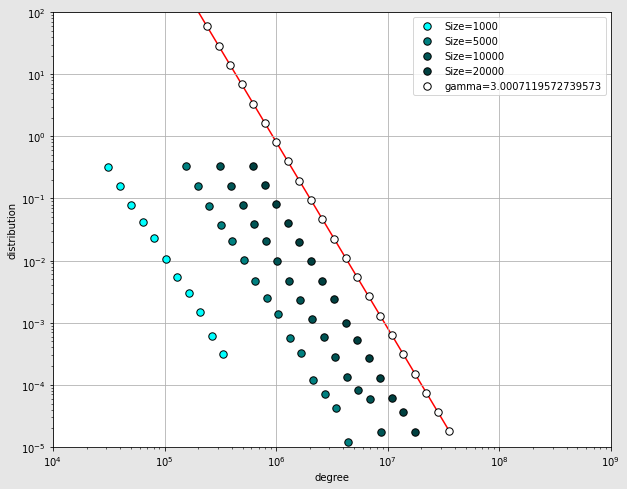

In [16]:
ba.loglog_plot(cutoff=11)